### Itroduction

#### Investing and especially trading has become more accessible to anyone
* high-speed internet
* low commissions
* wide-spread broker APIs
* plethora of financial data

**Caveat is that 95% of all individual traders fail, so one needs to be careful**
* addressed quite nicely by ML as one can optimize fro only high-confidence trades (more later)

### Problem Definition

**Focus on very short-term trading**
* short term make sense as long as you can make money (less longer-term uncertainty and black swans):
   * commissions are so favorable that multiple asset classes make sense
   * FX chosen (traded in pips (1 PIP = 0.0001 point
   )
   * round trip commission = EUR 4
       * 1.5 pips (1 pip = EUR 3) to profit on EUR 30,000 trade amount

### Main Question
**Can ML learn very short term patterns to allow for nimble profits**

Lets take a Data Science approach, rather than statistical

![EMA](\./resources/img/DS_Workflow_1.JPG)

![EMA](\./resources/img/DS_Workflow_2.JPG)

#### Raw Data Collection:
* Data between 2018-02-19 - 2019-08-02
* via IBKR API (Python)
   * http://interactivebrokers.github.io/tws-api/historical_bars.html#hd_request
* proper full app needed for this

![EMA](\./resources/img/Data_download.JPG)

#### Challenges
* took a while to customize IBKR's sample API code to serve my specific request
* there are hit limits so data download needed to be spread across time (overall took ~10 days)
* multithreading to make use of different connections at the same time to double efficiency
* select the right data granularity, given who it would be processed afterwards (tick vs 1 min, 5 min, etc)

* wrangle the raw data into OHLC 24-hour 1-second granularity dataframe
* storing the large datasets

![EMA](\./resources/img/Raw_Files.JPG)

### ML Setup

* time series
* 30 second frequency chosen based on volatility review to ensure enough meet is on the bone
* some FX training-specific nuances needed to be taken care of
    * 15 minute non-trading period daily
    * low-volatility vs high-volatility periods

![EMA](\./resources/img/Volatility.JPG)

### Imports, settings and options

In [1]:
# Imports
import pandas as pd
import os
import time
import patoolib
import gzip
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import datetime as dt
from tqdm import tqdm_notebook

# Options
resample_interval = "30S"

### Read in data

In [ ]:
patoolib.extract_archive(r"L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\EURUSD_all_files.pkl.gz", 
                         outdir=r"L:\Raw_1_sec_Bar_Data\FX\EURUSD\Pickle\\")

In [309]:
## Entire Dataset (pickle)
# EURGBP = pd.read_pickle(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Pickle\EURGBP.pkl")
# EURGBP.head()
## One File

EURGBP = pd.DataFrame()

for f in os.listdir(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted"):
    #if ("20180306" in f) | ("20180307" in f) | ("20180308" in f):
    if ("201802" in f) | ("20180301" in f) | ("20180302" in f):
        df = pd.read_csv(os.path.join("L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted",f), sep="|", index_col=0, parse_dates=True)
        EURGBP = pd.concat([EURGBP,df])
#         print(f)
        # EURGBP = pd.read_csv(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted\EURGBP_Bars_20180306.txt", sep="|", index_col=0, parse_dates=True)
EURGBP.head(10)

Open      High       Low     Close
DateTime_UTC                                               
2018-02-19 00:00:00  0.884600  0.884625  0.884600  0.884625
2018-02-19 00:00:01  0.884625  0.884650  0.884625  0.884650
2018-02-19 00:00:02  0.884650  0.884650  0.884650  0.884650
2018-02-19 00:00:03  0.884650  0.884650  0.884650  0.884650
2018-02-19 00:00:04  0.884650  0.884650  0.884650  0.884650
2018-02-19 00:00:05  0.884650  0.884650  0.884650  0.884650
2018-02-19 00:00:06  0.884650  0.884650  0.884650  0.884650
2018-02-19 00:00:07  0.884650  0.884650  0.884625  0.884650
2018-02-19 00:00:08  0.884650  0.884650  0.884650  0.884650
2018-02-19 00:00:09  0.884650  0.884650  0.884650  0.884650

### Resample

In [310]:
resampled_EURGBP = EURGBP.resample(resample_interval, label="right").agg({"Open":"first","High":"max","Low":"min","Close":"last"})
resampled_EURGBP.head(10)

Open      High       Low     Close
DateTime_UTC                                               
2018-02-19 00:00:30  0.884600  0.884650  0.884600  0.884625
2018-02-19 00:01:00  0.884625  0.884650  0.884625  0.884650
2018-02-19 00:01:30  0.884650  0.884700  0.884625  0.884700
2018-02-19 00:02:00  0.884700  0.884750  0.884700  0.884725
2018-02-19 00:02:30  0.884725  0.884875  0.884725  0.884850
2018-02-19 00:03:00  0.884850  0.884900  0.884825  0.884825
2018-02-19 00:03:30  0.884825  0.884925  0.884775  0.884875
2018-02-19 00:04:00  0.884875  0.884950  0.884875  0.884900
2018-02-19 00:04:30  0.884900  0.884900  0.884875  0.884875
2018-02-19 00:05:00  0.884875  0.884925  0.884875  0.884900

### Inspect data

In [ ]:
resampled_EURGBP.index

In [ ]:
resampled_EURGBP.tail()

In [397]:
resampled_EURGBP.shape

(34560, 4)

In [ ]:
resampled_EURGBP.info()

In [ ]:
resampled_EURGBP.describe()

### Time series and indicators exploration

#### Asses the right time to run the algorithm against
Run separately for:
* more volatile period
* less volatile period

In [ ]:
# Helper
# % change over each 10 minute period sequentially

fig3 = plt.figure(figsize=(17,17))

ax3 = fig3.add_subplot(211)
resampled_EURGBP.groupby(resampled_EURGBP.index.time)["Close_20_per_ago_%"].mean().plot(ax=ax3);
plt.title("% change over each 10 minute period sequentially", fontdict={"size":24})
plt.xlabel("Time", fontdict={"size":16})
# plt.xticklabels()
plt.xticks([0,23000.,63500.,81000.])
# ax3.get_xaxis().set_major_locator([1,2,3])
plt.ylabel("% change", fontdict={"size":16})
plt.show()

* #### Between 07:30 UTC and 20:00 UTC seems to be the volatility sweet spot
* #### Model should be able to handle this itself, so no need for manual filtering

## Features:
   * current OHLC
   * n_periods highs
   * n_periods lows
   * Bollinger Bands - Middle, Upper, Lower band
   * Stochastics - Fast, Slow stochastic
   * SMA - 9, 21, 10, 20, 50, 100, 200
   * EMA - 9, 21, 10, 20, 50, 100, 200
   
   * 60 period history for all above metrics

## Labels:

* 1 - long
* 0 - do nothing
* -1 - short



### Hard Work
* Splitting original 1.5 years worth of data into:
   * 2-week dataframes
   * 1-week dataframes
   * 1-month dataframes
* Assigning indicators and full price/indicator history to each dataframe
* Pickling and saving each fully pre-processed dataframe object

### Calculate indicators

#### Simple Moving Average

![SMA](\./resources/img/SMA.JPG)

In [7]:
# Series calc
def simple_MA(close_series, lookback=20):
    SMA = close_series.rolling(lookback).mean()

    return SMA #pd.Series(EMA,index=close_series.index)

#### Exponential Moving Average

![EMA](\./resources/img/EMA.JPG)

In [8]:
# Series calc
def exponential_MA(close_series, lookback=20):
    EMA = close_series.ewm(lookback).mean()

    #     EMA = []
#     K = 2/(lookback+1)
# #     SMA = close_series.rolling(lookback).mean()
#     [EMA.append(close_series.iloc[0]) if c==0 else EMA.append(K*v+(1-K)*EMA[-1]) for c,v in enumerate(close_series.shift(1))]
# #     EMA = K*close_series.shift(1)+(1-K)*EMA.shift(1)

    return EMA

#### Bollinger Bands

![Bollinger_Bands](\./resources/img/Bollinger_Bands_Formula.gif)

In [9]:
# Series calc
def bollinger_bands(high_series, low_series, close_series, lookback=20):
    TP = ((high_series + low_series + close_series)/3).rolling(lookback)
    MidBand = TP.mean()
    F = 2
    UpperBand = MidBand + (F*TP.std())
    LowerBand = MidBand - (F*TP.std())
    
    return MidBand, UpperBand, LowerBand

#### Stochastic Oscilator

![Stochastics](\./resources/img/Stochastics.PNG)

In [314]:
# Series calc
def stochastics(high_series, low_series, close_series, lookback=14, smoothing_per=3):
    # normally a 14 period
    percent_K = 100*((close_series - low_series.rolling(lookback).min())/
                     (high_series.rolling(lookback).max()-low_series.rolling(lookback).min()))
    # Fill NaN in percent_K with prior value
    percent_K.fillna(method="ffill", inplace=True)
    # smoothing_per = to smooth the percent_K
    percent_D = percent_K.rolling(smoothing_per).mean()
    Fast_Stoch = percent_D
    Slow_Stoch = percent_D.rolling(smoothing_per).mean() # one more smoothing of percent_D
    return Fast_Stoch, Slow_Stoch

In [315]:
resampled_EURGBP.dropna(inplace=True)

In [ ]:
resampled_EURGBP.isna().sum()

#### Assigning indicators to dataframe

In [317]:
# Parameters
max_min_periods = [20,30,40,50,60,70,80,100,120,180,190,200,210,220,230,240,300,360,420,480]
BB_periods = [30,40,50,60,70,80,90,100,150,200,300] # 10,20,30,40,60,70,80
Stoch_periods = [14,28,42,56,70,84,98]
Smooth_periods = [3,6,9,12,15,18,21]
SMA_periods = [5,9,10,11,13,20,21,30,40,50,100,150,200]
EMA_periods = [5,9,10,11,13,20,21,30,40,50,100,150,200]

In [318]:
def assign_indicators(resampled_EURGBP):
    # Highs and Lows over 1h 45m and other periods
    for period in max_min_periods:
        resampled_EURGBP[f"Max_{period}_per"] = resampled_EURGBP["Close"].rolling(period).max()
        resampled_EURGBP[f"Min_{period}_per"] = resampled_EURGBP["Close"].rolling(period).min()
    # Bollinger Band
    for period in BB_periods:
        resampled_EURGBP[f"BB_middle_band_{period}_per"], resampled_EURGBP[f"BB_upper_band_{period}_per"], resampled_EURGBP[f"BB_lower_band_{period}_per"] = bollinger_bands(resampled_EURGBP["High"], resampled_EURGBP["Low"], resampled_EURGBP["Close"], period)
    # Stochastics
    for period in Stoch_periods:
        for smoothing in Smooth_periods:
            resampled_EURGBP[f"Fast_Stoch_{period}_per_{smoothing}_smoothing"], resampled_EURGBP[f"Slow_Stoch_{period}_per_{smoothing}_smoothing"]  = stochastics(resampled_EURGBP["High"], resampled_EURGBP["Low"], resampled_EURGBP["Close"], period, smoothing)
    # SMA
    for period in SMA_periods:
        resampled_EURGBP[f"SMA_{period}"] = simple_MA(resampled_EURGBP["Close"], period)
    # EMA
    for period in EMA_periods:
        resampled_EURGBP[f"EMA_{period}"] = exponential_MA(resampled_EURGBP["Close"], period)
    
    return resampled_EURGBP

In [319]:
resampled_EURGBP.shape

(28290, 4)

#### Assigning last 60 periods(30 mins) woth of history to all prices and indicators

In [320]:
def populate_history(resampled_EURGBP):
    start_time = dt.datetime.now()
    # Assigning past 60 periods (30 mins) of price changes to dataframe
    for counter in tqdm_notebook(range(1,61), leave=False, desc="Close loop"):
        resampled_EURGBP[f"Close_{counter}_per_ago_%"] = resampled_EURGBP["Close"].pct_change(counter)*100
    #     [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP["Close"].iloc[c-counter])/resampled_EURGBP["Close"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP["Close"])]

    for counter in tqdm_notebook(range(1,61), leave=False, desc="Open loop"):
        resampled_EURGBP[f"Open_{counter}_per_ago_%"] = resampled_EURGBP["Open"].pct_change(counter)*100
    #     [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP["Open"].iloc[c-counter])/resampled_EURGBP["Open"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP["Open"])]

    for counter in tqdm_notebook(range(1,61), leave=False, desc="High loop"):
        resampled_EURGBP[f"High_{counter}_per_ago_%"] = resampled_EURGBP["High"].pct_change(counter)*100
    #     [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP["High"].iloc[c-counter])/resampled_EURGBP["High"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP["High"])]

    for counter in tqdm_notebook(range(1,61), leave=False, desc="Low loop"):
        resampled_EURGBP[f"Low_{counter}_per_ago_%"] = resampled_EURGBP["Low"].pct_change(counter)*100
    #     [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP["Low"].iloc[c-counter])/resampled_EURGBP["Low"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP["Low"])]


    # Assigning past 60 periods (30 mins) of maxs to dataframe
    for period in tqdm_notebook(max_min_periods, leave=False, desc="1st Max loop"):
        for counter in tqdm_notebook(range(1,61), leave=False, desc="2nd Max loop"):
            resampled_EURGBP[f"Max_{period}_per_{counter}_per_ago_%"] = resampled_EURGBP[f"Max_{period}_per"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"Max_{period}_per"].iloc[c-counter])/resampled_EURGBP[f"Max_{period}_per"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"Max_{period}_per"])]


    # Assigning past 60 periods (30 mins) of mins to dataframe
    for period in tqdm_notebook(max_min_periods, leave=False, desc="1st Min loop"):
        for counter in tqdm_notebook(range(1,61), leave=False, desc="2nd Min loop"):
            resampled_EURGBP[f"Min_{period}_per_{counter}_per_ago_%"] = resampled_EURGBP[f"Min_{period}_per"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"Min_{period}_per"].iloc[c-counter])/resampled_EURGBP[f"Min_{period}_per"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"Min_{period}_per"])]


    # Assigning past 60 periods (30 mins) of Mid_Bol, U_Bol, L_Bol changes to dataframe
    for period in tqdm_notebook(BB_periods, leave=False, desc="1st BB loop"):
        for counter in tqdm_notebook(range(1,61), leave=False, desc="2nd BB loop"):
            resampled_EURGBP[f"BB_middle_band_{period}_per_{counter}_per_ago_%"] = resampled_EURGBP[f"BB_middle_band_{period}_per"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"BB_middle_band_{period}_per"].iloc[c-counter])/resampled_EURGBP[f"BB_middle_band_{period}_per"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"BB_middle_band_{period}_per"])]
            resampled_EURGBP[f"BB_upper_band_{period}_per_{counter}_per_ago_%"] = resampled_EURGBP[f"BB_upper_band_{period}_per"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"BB_upper_band_{period}_per"].iloc[c-counter])/resampled_EURGBP[f"BB_upper_band_{period}_per"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"BB_upper_band_{period}_per"])]
            resampled_EURGBP[f"BB_lower_band_{period}_per_{counter}_per_ago_%"] = resampled_EURGBP[f"BB_lower_band_{period}_per"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"BB_lower_band_{period}_per"].iloc[c-counter])/resampled_EURGBP[f"BB_lower_band_{period}_per"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"BB_lower_band_{period}_per"])]


    # Assigning past 60 periods (30 mins) of Fast_Stoch, Slow_Stoch changes to dataframe
    for period in tqdm_notebook(Stoch_periods, leave=False, desc="1st Stoch loop"):
        for smoothing in tqdm_notebook(Smooth_periods, leave=False, desc="2nd Stoch loop"):
            for counter in tqdm_notebook(range(1,61), leave=False, desc="3rd Stoch loop"):
                resampled_EURGBP[f"Fast_Stoch_{period}_per_{smoothing}_smoothing_{counter}_per_ago_%"] = resampled_EURGBP[f"Fast_Stoch_{period}_per_{smoothing}_smoothing"].pct_change(counter)*100
    #             [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"Fast_Stoch_{period}_per_{smoothing}_smoothing"].iloc[c-counter])/resampled_EURGBP[f"Fast_Stoch_{period}_per_{smoothing}_smoothing"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"Fast_Stoch_{period}_per_{smoothing}_smoothing"])]
                resampled_EURGBP[f"Slow_Stoch_{period}_per_{smoothing}_smoothing_{counter}_per_ago_%"] = resampled_EURGBP[f"Slow_Stoch_{period}_per_{smoothing}_smoothing"].pct_change(counter)*100
    #     [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"Slow_Stoch_{period}_per_{smoothing}_smoothing"].iloc[c-counter])/resampled_EURGBP[f"Slow_Stoch_{period}_per_{smoothing}_smoothing"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"Slow_Stoch_{period}_per_{smoothing}_smoothing"])]


    # Assigning past 60 periods (30 mins) of SMA changes to dataframe
    for period in tqdm_notebook(SMA_periods, leave=False, desc="1st SMA loop"):
        for counter in tqdm_notebook(range(1,61), leave=False, desc="2nd SMA loop"):
            resampled_EURGBP[f"SMA_{period}_{counter}_per_ago_%"] = resampled_EURGBP[f"SMA_{period}"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"SMA_{period}"].iloc[c-counter])/resampled_EURGBP[f"SMA_{period}"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"SMA_{period}"])]


    # Assigning past 60 periods (30 mins) of EMA changes to dataframe
    for period in tqdm_notebook(EMA_periods, leave=False, desc="1st EMA loop"):
        for counter in tqdm_notebook(range(1,61), leave=False, desc="2nd EMA loop"):
            resampled_EURGBP[f"EMA_{period}_{counter}_per_ago_%"] = resampled_EURGBP[f"EMA_{period}"].pct_change(counter)*100
    #         [np.nan if c<counter
    #                                                 else ((v - resampled_EURGBP[f"EMA_{period}"].iloc[c-counter])/resampled_EURGBP[F"EMA_{period}"].iloc[c-counter])*100
    #                                                 for c,v in enumerate(resampled_EURGBP[f"EMA_{period}"])]

    return resampled_EURGBP



print(dt.datetime.now() - start_time)

In [ ]:
import pickle

EURGBP = pd.DataFrame()
two_weeks_files = []
counter = 0
folder = "E:\\Pickles\\"

for f in os.listdir(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted"):
    all_files_list.append(f)
#     counter.append(f)
#     final = [v if (c+1) % 12 == 0 else v if c == 0 else 0for c,v in enumerate(os.listdir(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted"))]
    if (counter+1) % 12 == 0:
        two_weeks_files.append(f)
    elif counter == 0:
        two_weeks_files.append(f)
    counter+=1

for r in range(len(two_weeks_files)):
    try:
        first_file = all_files_list.index(two_weeks_files[r])
        first_file_name = two_weeks_files[r]
        second_file = all_files_list.index(two_weeks_files[r+1])
        second_file_name = two_weeks_files[r+1]
        
        for file in all_files_list[first_file:second_file]:
            df = pd.read_csv(os.path.join("L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted",file), sep="|", index_col=0, parse_dates=True)
            EURGBP = pd.concat([EURGBP,df])
        
        resampled_EURGBP = EURGBP.resample(resample_interval, label="right").agg({"Open":"first","High":"max","Low":"min","Close":"last"})
        
        resampled_EURGBP.dropna(inplace=True)
        
        resampled_EURGBP = assign_indicators(resampled_EURGBP)
        resampled_EURGBP = populate_history(resampled_EURGBP)
        resampled_EURGBP = assign_target(resampled_EURGBP, pips, target_distance_into_future)
        
        with open(folder+"two_weeks_files\\EURGBP_two_weeks_files_"+first_file_name[0:len(first_file_name)-4]+
                       "_"+second_file_name[0:len(second_file_name)-4]+".pkl","wb") as pickle_file:
            pickle.dump(resampled_EURGBP, pickle_file)
        EURGBP = pd.DataFrame()
    except IndexError:
        pass

    
EURGBP = pd.DataFrame()
all_files_list = []
one_week_files = []
counter = 0

for f in os.listdir(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted"):
    all_files_list.append(f)
    if (counter+1) % 6 == 0:
        one_week_files.append(f)
    elif counter == 0:
        one_week_files.append(f)
    counter+=1

for r in range(len(one_week_files)):
    try:
        first_file = all_files_list.index(one_week_files[r])
        first_file_name = one_week_files[r]
        second_file = all_files_list.index(one_week_files[r+1])
        second_file_name = one_week_files[r+1]
        
        for file in all_files_list[first_file:second_file]:
            df = pd.read_csv(os.path.join("L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted",file), sep="|", index_col=0, parse_dates=True)
            EURGBP = pd.concat([EURGBP,df])
        
        resampled_EURGBP = EURGBP.resample(resample_interval, label="right").agg({"Open":"first","High":"max","Low":"min","Close":"last"})
        
        resampled_EURGBP.dropna(inplace=True)
        
        resampled_EURGBP = assign_indicators(resampled_EURGBP)
        resampled_EURGBP = populate_history(resampled_EURGBP)
        resampled_EURGBP = assign_target(resampled_EURGBP, pips, target_distance_into_future)
        
        with open(folder+"one_week_files\\EURGBP_one_week_files_"+first_file_name[0:len(first_file_name)-4]+
                       "_"+second_file_name[0:len(second_file_name)-4]+".pkl","wb") as pickle_file:
            pickle.dump(resampled_EURGBP, pickle_file)
        EURGBP = pd.DataFrame()
    except IndexError:
        pass


EURGBP = pd.DataFrame()
all_files_list = []
one_month_files = []
counter = 0

for f in os.listdir(r"L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted"):
    all_files_list.append(f)
    if (counter+1) % 24 == 0:
        one_month_files.append(f)
    elif counter == 0:
        one_month_files.append(f)
    counter+=1

for r in range(len(one_month_files)):
    try:
        first_file = all_files_list.index(one_month_files[r])
        first_file_name = one_month_files[r]
        second_file = all_files_list.index(one_month_files[r+1])
        second_file_name = one_month_files[r+1]
        
        for file in all_files_list[first_file:second_file]:
            df = pd.read_csv(os.path.join("L:\Raw_1_sec_Bar_Data\FX\EURGBP\Extracted",file), sep="|", index_col=0, parse_dates=True)
            EURGBP = pd.concat([EURGBP,df])
        
        resampled_EURGBP = EURGBP.resample(resample_interval, label="right").agg({"Open":"first","High":"max","Low":"min","Close":"last"})
        
        resampled_EURGBP.dropna(inplace=True)
        
        resampled_EURGBP = assign_indicators(resampled_EURGBP)
        resampled_EURGBP = populate_history(resampled_EURGBP)
        resampled_EURGBP = assign_target(resampled_EURGBP, pips, target_distance_into_future)
        
        with open(folder+"one_month_files\\EURGBP_one_month_files_"+first_file_name[0:len(first_file_name)-4]+
                       "_"+second_file_name[0:len(second_file_name)-4]+".pkl","wb") as pickle_file:
            pickle.dump(resampled_EURGBP, pickle_file)
        EURGBP = pd.DataFrame()
    except IndexError:
        pass

#### Save as pickle

In [452]:
resampled_EURGBP.shape

(28290, 13521)

![EMA](\./resources/img/Pickled.JPG)

### Statistical analysis to choose trading period (target)

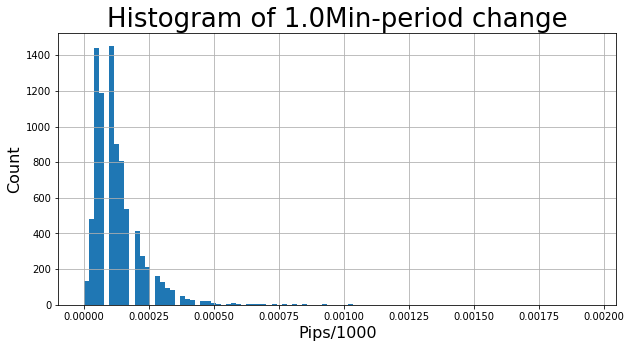

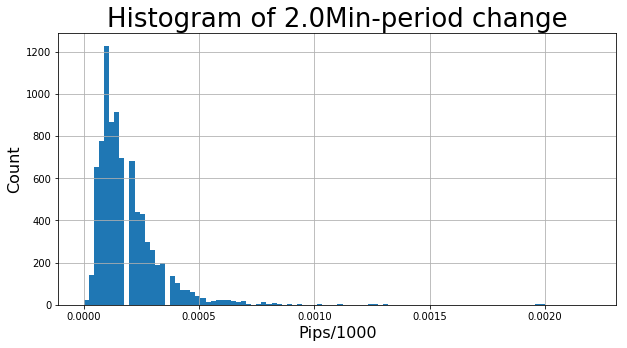

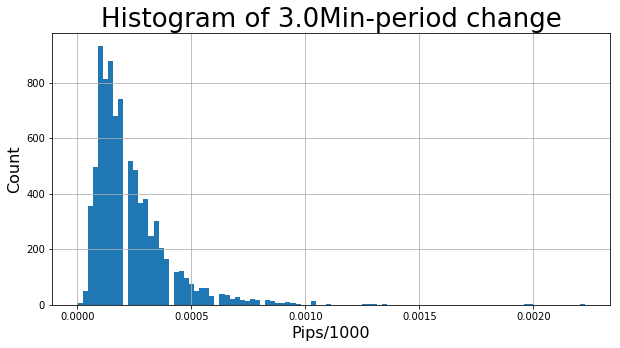

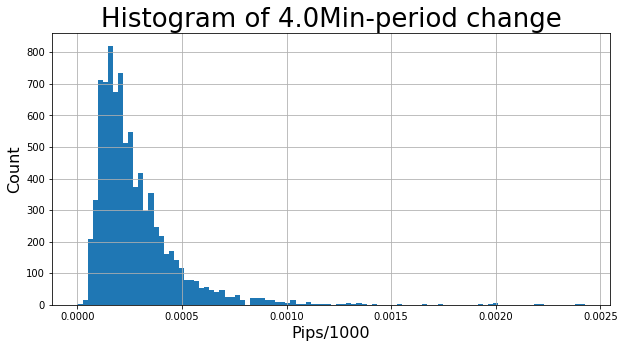

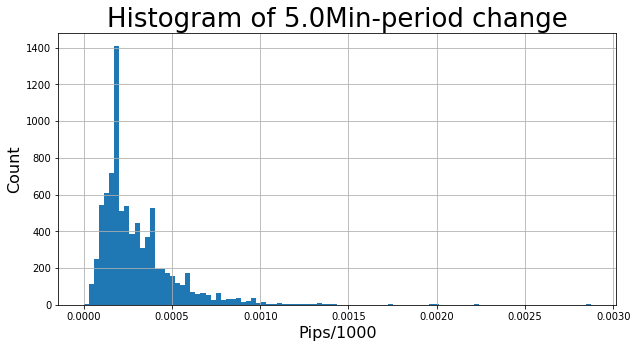

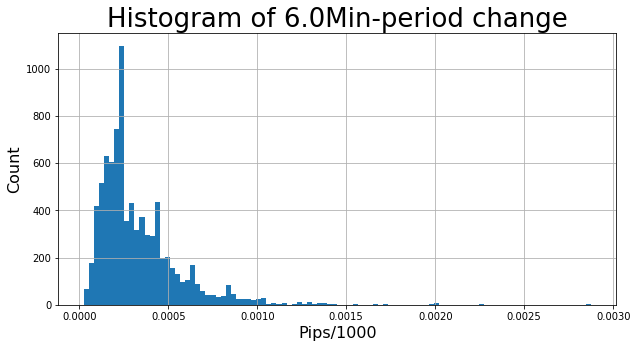

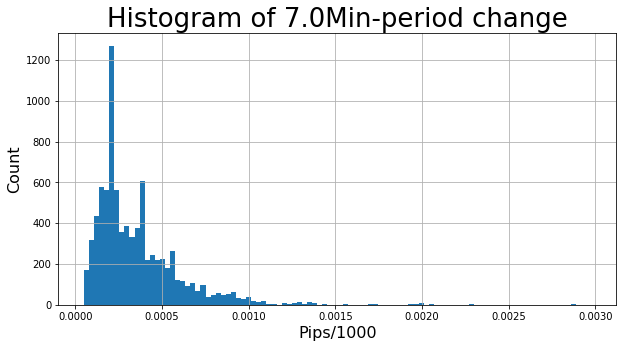

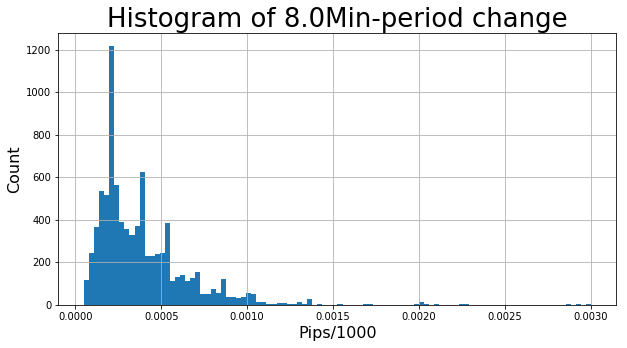

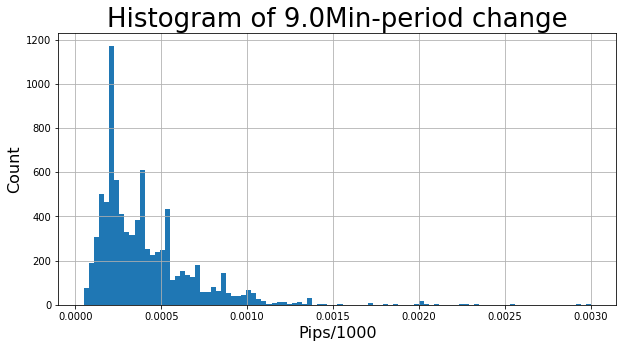

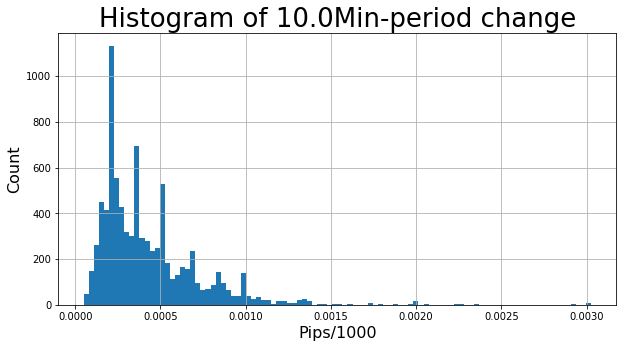

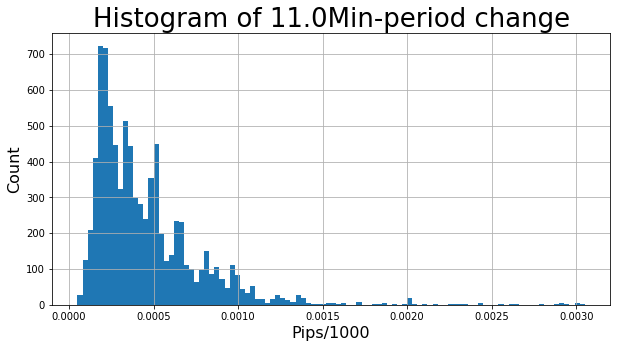

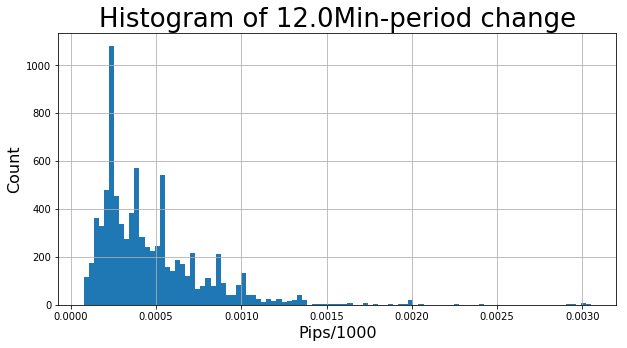

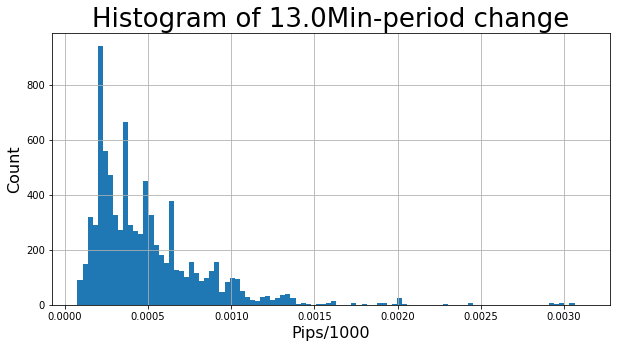

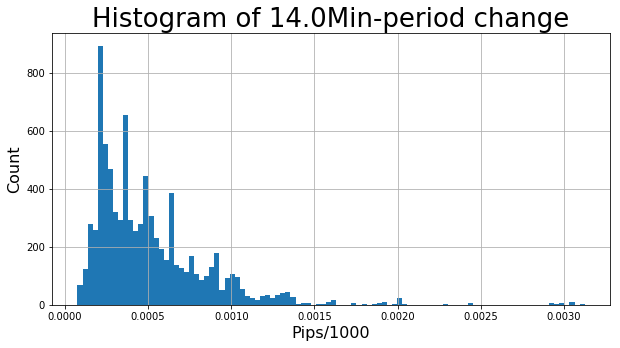

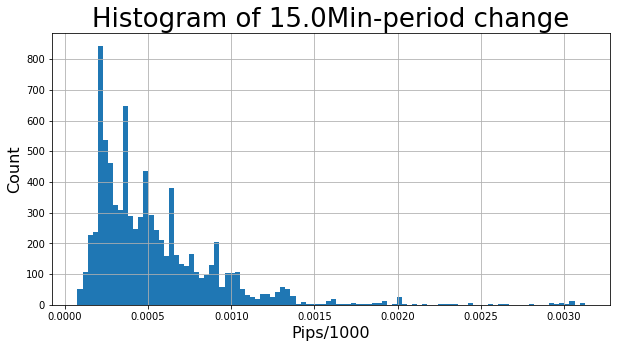

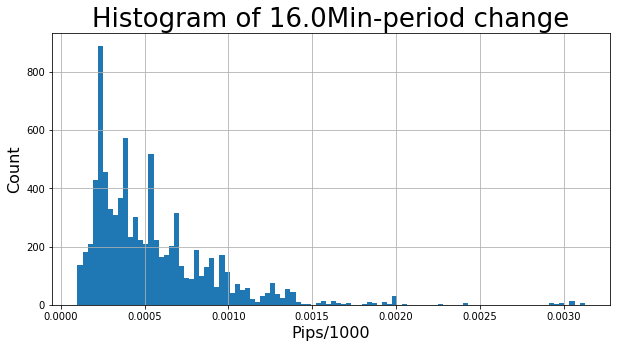

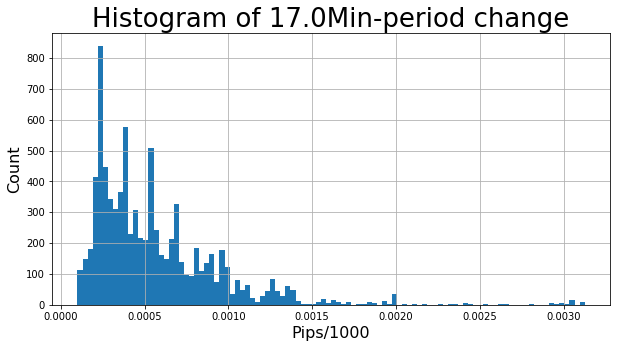

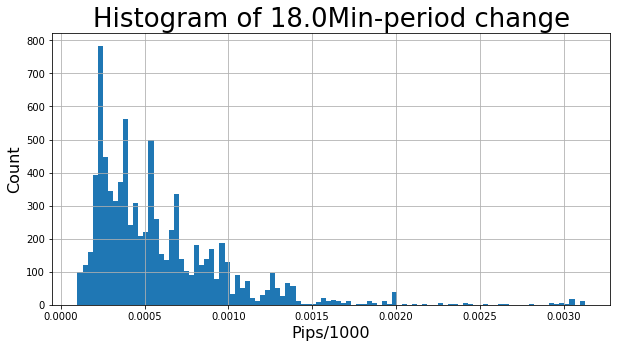

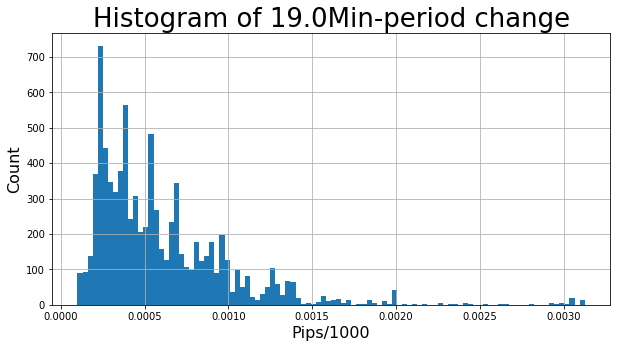

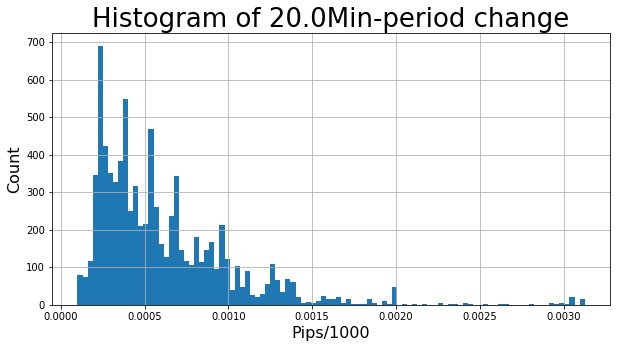

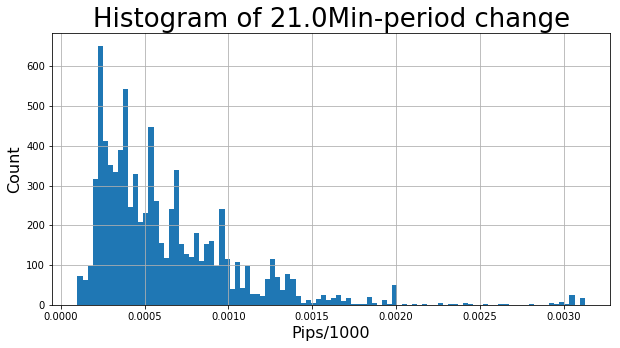

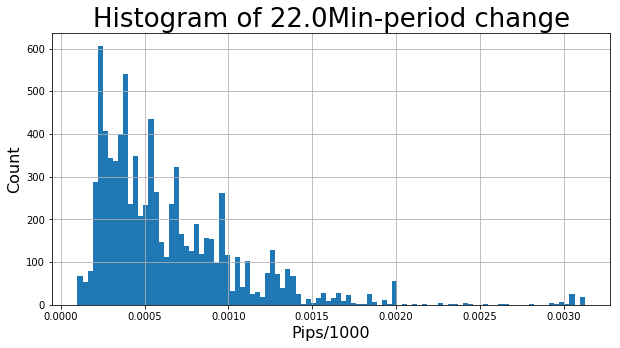

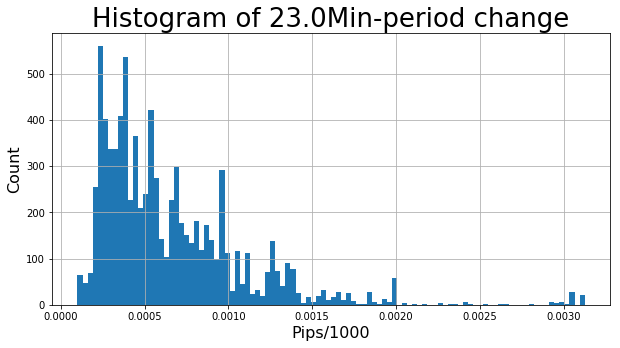

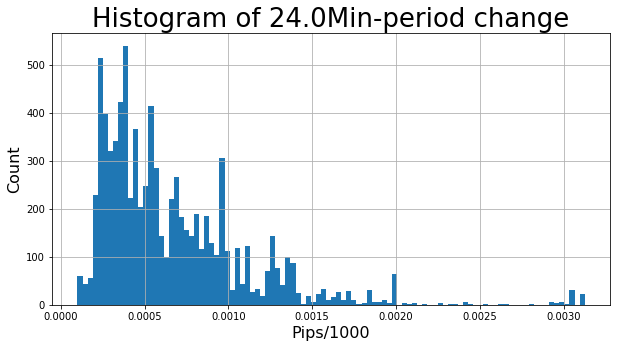

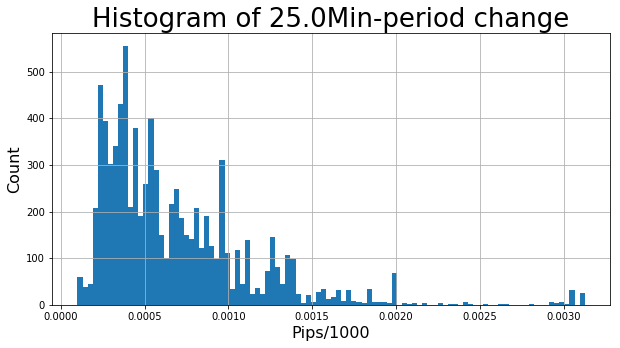

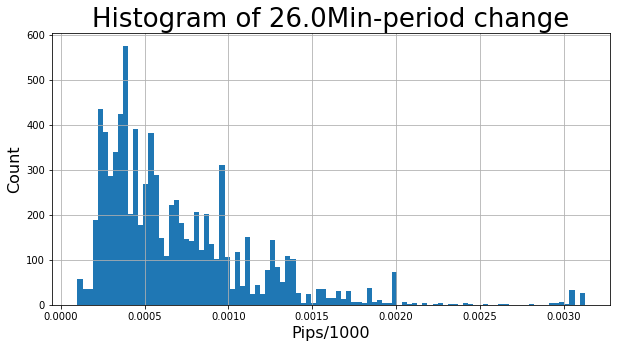

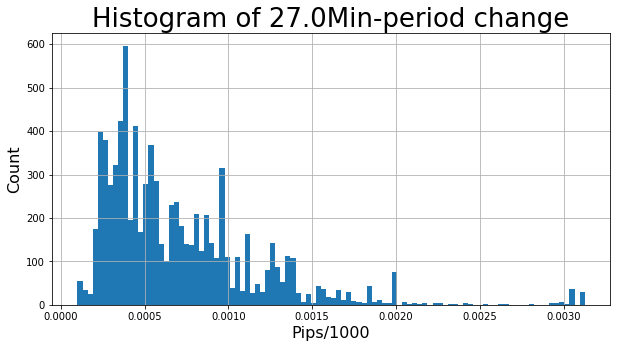

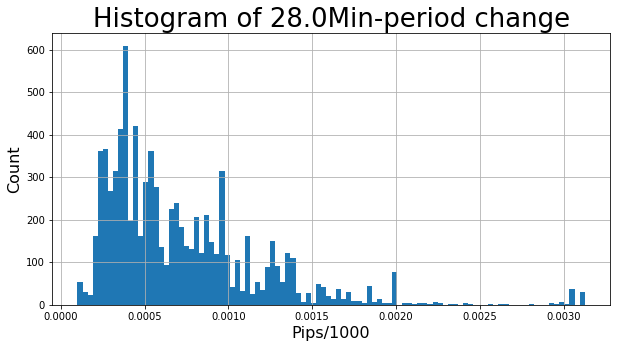

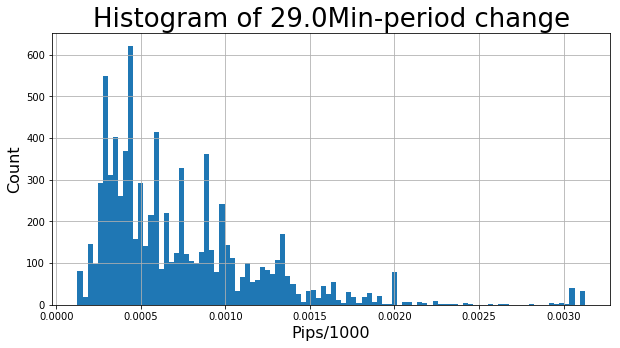

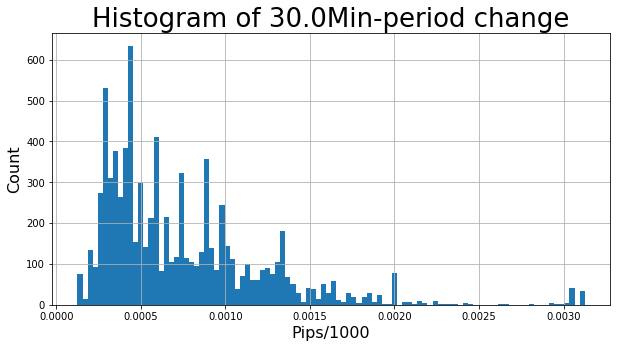

In [216]:
# histogram of n-period price change
# helps determine how far ahead should a target predicton timeframe be

n_list = ["2Min", "3Min", "5Min", "5Min", "5Min"]

for n in range(2,61,2): # up to 30 mins
    resampled_EURGBP_High_Low = resampled_EURGBP.loc[:,["High", "Low"]]
    resampled_EURGBP_High_Low_Change = resampled_EURGBP_High_Low["High"].rolling(n).max() - resampled_EURGBP_High_Low["Low"].rolling(n).min()
    resampled_EURGBP_High_Low_Change.hist(bins=100, figsize=(10,5));
#     resampled_EURGBP_High_Low.rolling(n).agg({"High":"max", "low":"min"})
#     resampled_EURGBP_Close_1_per_change.resample(f"{n}Min").sum().hist(bins=100, figsize=(10,5));
    plt.xlabel("Pips/1000",fontsize=16);
    plt.ylabel("Count",fontsize=16);
    plt.title(f"Histogram of {(n*30)/60}Min-period change",fontsize=26);
    plt.show()

1.0 Min Period: 9.95370370370371% of all price changes are more than 0.00025 pips
1.5 Min Period: 16.111111111111114% of all price changes are more than 0.00025 pips
2.0 Min Period: 22.22222222222223% of all price changes are more than 0.00025 pips
2.5 Min Period: 27.754629629629633% of all price changes are more than 0.00025 pips
3.0 Min Period: 32.83564814814815% of all price changes are more than 0.00025 pips
3.5 Min Period: 37.048611111111114% of all price changes are more than 0.00025 pips
4.0 Min Period: 40.844907407407405% of all price changes are more than 0.00025 pips
4.5 Min Period: 44.40972222222222% of all price changes are more than 0.00025 pips
5.0 Min Period: 47.5% of all price changes are more than 0.00025 pips
5.5 Min Period: 49.988425925925924% of all price changes are more than 0.00025 pips
6.0 Min Period: 52.25694444444444% of all price changes are more than 0.00025 pips
6.5 Min Period: 54.363425925925924% of all price changes are more than 0.00025 pips
7.0 Min Peri

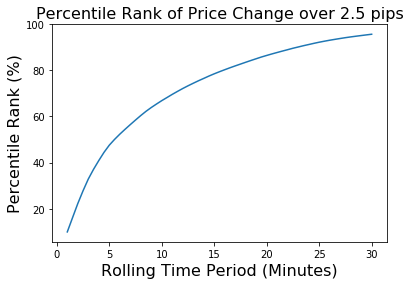

In [217]:
# Percentile Rank of Price Change (pips) for each of above histograms
# helps determine what the optimial rolling window far target predicton timeframe is
# Choose the one with significant spike in percentile rank as soon as possible

pips = 0.00025

def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1
    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

prds_list = []
pct_above_pips_list = []

for n in range(2,61): # up to 30 mins
    resampled_EURGBP_High_Low = resampled_EURGBP.loc[:,["High", "Low"]]
    resampled_EURGBP_High_Low_Change = resampled_EURGBP_High_Low["High"].rolling(n).max() - resampled_EURGBP_High_Low["Low"].rolling(n).min()
    ordered_resampled_EURGBP_High_Low_Change = resampled_EURGBP_High_Low_Change.sort_values()

#     resampled_EURGBP_Close_1_per_change = resampled_EURGBP.loc[:,"Close_1_per_ago"]
#     ordered_resampled_EURGBP_Close_1_per_change = np.absolute(resampled_EURGBP_Close_1.resample(f"{n}Min").sum()).sort_values()
    pct_above_pips = 100 - PercentileRank(resampled_EURGBP_High_Low_Change,pips)
    prds = (n*30)/60
    prds_list.append(prds)
    pct_above_pips_list.append(pct_above_pips)
    print(f"{prds} Min Period: {pct_above_pips}% of all price changes are more than {pips} pips")

plt.plot(prds_list, pct_above_pips_list);
plt.xlabel("Rolling Time Period (Minutes)",fontsize=16);
plt.ylabel("Percentile Rank (%)",fontsize=16);
plt.title(f"Percentile Rank of Price Change over {pips*10000} pips",fontsize=16);

#### Preprocessing target
Populating target column with value generating biggest potential of at least "pips" move over as shot time horizon as possible

In [49]:
target_distance_into_future = 12
pips = 0.00025

def assign_target(resampled_EURGBP, pips, target_distance_into_future):
    resampled_EURGBP[f"Price_change_{target_distance_into_future}_per_forward"] = [1 if v>=pips else -1 if v<=-pips else 0 for v in resampled_EURGBP["Close"].diff(f"{-target_distance_into_future}")]
    return resampled_EURGBP

#### Target class imbalance

In [133]:
resampled_EURGBP["Price_change_12_per_forward"].value_counts()

 0    6896
 1     859
-1     795
Name: Price_change_12_per_forward, dtype: int64

In [ ]:
# Helper

from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

resampled_EURGBP["New_Date"] = [dt.date(1,1,1) + dt.timedelta(days=x) for x in range(1, resampled_EURGBP.shape[0]+1)]

# Rows to Chart:
rows_to_chart = range(1150,1360)

#   For CANDLE chart:
min_1_analyzed_df_candle_chart = resampled_EURGBP.loc[resampled_EURGBP.index[rows_to_chart],
                                                       ["Open", "High","Low", 
                                                        "Close", "Fast_Stoch", "Slow_Stoch", 
                                                        "U_Bol", "L_Bol", "Mid_Bol", "EMA", 
                                                       "SMA"]].set_index(resampled_EURGBP.loc[resampled_EURGBP.index[rows_to_chart],'New_Date'])

mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12
hourFormatter = DateFormatter('%h')

fig1 = plt.figure(figsize=(15,15))
ax10 = plt.subplot(2,1,1)
fig1.subplots_adjust(bottom=0.2)
# ax10.xaxis.set_major_locator(mondays)
# ax10.xaxis.set_minor_locator(alldays)
# ax10.xaxis.set_major_formatter(dayFormatter)
ax10.xaxis.set_minor_formatter(hourFormatter)

### Charting by actual dates on X asis:
candlestick_ohlc(ax10, zip(mdates.date2num(min_1_analyzed_df_candle_chart.index),
                         min_1_analyzed_df_candle_chart['Open'], min_1_analyzed_df_candle_chart['High'],
                         min_1_analyzed_df_candle_chart['Low'], min_1_analyzed_df_candle_chart['Close']), width=0.6)
### Charting by intigers (converted to dates on the chart) on X asis:
# candlestick_ohlc(ax10, zip(min_1_analyzed_df_candle_chart.index,
#                           min_1_analyzed_df_candle_chart['Open'], min_1_analyzed_df_candle_chart['High'],
#                           min_1_analyzed_df_candle_chart['Low'], min_1_analyzed_df_candle_chart['Close']), width=0.6)

# Plotting Stochastics
ax11 = plt.subplot(2,1,2)
# min_1_analyzed_df_candle_chart["Fast_Stoch"].plot(ax=ax11, color="r", sharex=True)
# min_1_analyzed_df_candle_chart["Slow_Stoch"].plot(ax=ax11, color="y", sharex=True)
# Plotting Bollinger Bands
min_1_analyzed_df_candle_chart["U_Bol"].plot(ax=ax10, color="b")
min_1_analyzed_df_candle_chart["L_Bol"].plot(ax=ax10, color="b")
min_1_analyzed_df_candle_chart["Mid_Bol"].plot(ax=ax10, color="g")
# Plotting EMA
# min_1_analyzed_df_candle_chart["EMA"].plot(ax=ax10, color="b")
# Plotting SMA
# min_1_analyzed_df_candle_chart["SMA"].plot(ax=ax10, color="g")


plt.xlim(left=1)
ax10.xaxis_date()
ax10.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [784]:
# Helper
# For charting
resampled_EURGBP["Mid_Bol"], resampled_EURGBP["U_Bol"], resampled_EURGBP["L_Bol"]  = bollinger_bands(resampled_EURGBP["High"], resampled_EURGBP["Low"], resampled_EURGBP["Close"], 50)
# resampled_EURGBP["Fast_Stoch"], resampled_EURGBP["Slow_Stoch"] = stochastics(resampled_EURGBP["High"], resampled_EURGBP["Low"], resampled_EURGBP["Close"], 56, 12)
# resampled_EURGBP["EMA"] = exponential_MA(resampled_EURGBP["Close"], 20)
# resampled_EURGBP["SMA"] = simple_MA(resampled_EURGBP["Close"], 20)

In [ ]:
# Helper
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(1,1,1)
Fast_Stoch.head(100).plot(kind="line",ax=ax2);
Slow_Stoch.head(100).plot(kind="line",ax=ax2);

### Machine Lerning

#### Main algorithm: CatBoost

### Decicion Tree

![EMA](\./resources/img/Tree.JPG)

### Random Forest

![EMA](\./resources/img/Forest.JPG)

### Gradient Boosting

![EMA](\./resources/img/Boosting.JPG)

#### Load data from pickle

In [ ]:
import pickle

with (open(os.path.join(folder,"EURGBP_two_weeks_files_EURGBP_Bars_20180304_EURGBP_Bars_20180318.pkl"), "rb")) as file:
    resampled_EURGBP = pickle.load(file)

In [ ]:
folder = "E:\\Pickles\\two_weeks_files"
with (open(os.path.join(folder,"EURGBP_two_weeks_files_EURGBP_Bars_20180304_EURGBP_Bars_20180318.pkl"), "rb")) as file:
    resampled_EURGBP = pickle.load(file)
resampled_EURGBP.head()

In [ ]:
# Helper
resampled_EURGBP.dtypes

In [16]:
resampled_EURGBP.head()

Open      High       Low     Close    Max_20_per  \
DateTime_UTC                                                                
2018-03-04 22:15:30  0.894825  0.894900  0.894625  0.894900 -1.000000e+18   
2018-03-04 22:16:00  0.894900  0.894950  0.894875  0.894925 -1.000000e+18   
2018-03-04 22:16:30  0.894925  0.894975  0.894850  0.894850 -1.000000e+18   
2018-03-04 22:17:00  0.894850  0.894975  0.894825  0.894925 -1.000000e+18   
2018-03-04 22:17:30  0.894925  0.894925  0.894750  0.894750 -1.000000e+18   

                       Min_20_per    Max_30_per    Min_30_per    Max_40_per  \
DateTime_UTC                                                                  
2018-03-04 22:15:30 -1.000000e+18 -1.000000e+18 -1.000000e+18 -1.000000e+18   
2018-03-04 22:16:00 -1.000000e+18 -1.000000e+18 -1.000000e+18 -1.000000e+18   
2018-03-04 22:16:30 -1.000000e+18 -1.000000e+18 -1.000000e+18 -1.000000e+18   
2018-03-04 22:17:00 -1.000000e+18 -1.000000e+18 -1.000000e+18 -1.000000e+18   
2018-03-04 22:17:30 -1.000000e+18 -1.000000e+18 -1.000000e+18 -1.000000e+18   

                       Min_40_per  ...  EMA_200_52_per_ago_%  \
DateTime_UTC                       ...                         
2018-03-04 22:15:30 -1.000000e+18  ...         -1.000000e+18   
2018-03-04 22:16:00 -1.000000e+18  ...         -1.000000e+18   
2018-03-04 22:16:30 -1.000000e+18  ...         -1.000000e+18   
2018-03-04 22:17:00 -1.000000e+18  ...         -1.000000e+18   
2018-03-04 22:17:30 -1.000000e+18  ...         -1.000000e+18   

                     EMA_200_53_per_ago_%  EMA_200_54_per_ago_%  \
DateTime_UTC                                                      
2018-03-04 22:15:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:30         -1.000000e+18         -1.000000e+18   

                     EMA_200_55_per_ago_%  EMA_200_56_per_ago_%  \
DateTime_UTC                                                      
2018-03-04 22:15:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:30         -1.000000e+18         -1.000000e+18   

                     EMA_200_57_per_ago_%  EMA_200_58_per_ago_%  \
DateTime_UTC                                                      
2018-03-04 22:15:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:30         -1.000000e+18         -1.000000e+18   

                     EMA_200_59_per_ago_%  EMA_200_60_per_ago_%  \
DateTime_UTC                                                      
2018-03-04 22:15:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:16:30         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:00         -1.000000e+18         -1.000000e+18   
2018-03-04 22:17:30         -1.000000e+18         -1.000000e+18   

                     Price_change_12_per_forward  
DateTime_UTC                                      
2018-03-04 22:15:30                            1  
2018-03-04 22:16:00                            0  
2018-03-04 22:16:30                            0  
2018-03-04 22:17:00                            1  
2018-03-04 22:17:30                            0  

[5 rows x 12262 columns]

#### Class weights

In [242]:
# Class proportions
resampled_EURGBP["Price_change_12_per_forward"].value_counts(normalize=True)

 0    0.825474
 1    0.094386
-1    0.080140
Name: Price_change_12_per_forward, dtype: float64

#### 1) Class imbalance makes a huge difference in final result
* 100 iterations training reveals:

|Class | Proportion|Precision (unballanced)|Factor|Precision (ballanced by factor)|
|-------|----------|-------------|-------------|-------------|
|0  |  0.806550|0.970345963|1|0.7938689|
|1  |  0.100468|0.6126482|8.132738556240634|0.927865563|
|-1  |  0.092982|0.61607142|8.787412785010977|0.92867740|
* Accuracy and recall largelly unchanged


In [4]:
print("If dominant class (0) has got weight of 1 then:")
print(" ")
print("Weigh of class 1 ought to be:",0.808565/0.099421)
print("Weight of class -1 ought to be:",0.808565/0.092014)

If dominant class (0) has got weight of 1 then:
 
Weigh of class 1 ought to be: 8.132738556240634
Weight of class -1 ought to be: 8.787412785010977


To assign class_weights:
https://stackoverflow.com/questions/57565510/usage-of-class-weights-in-catboostclassifier/60332823#60332823

or

each observation can be assigned its own weight (equal per class, in my case): resampled_EURGBP["Price_change_12_per_forward_weight"]

Based on test model fit, the order of classes is: [-1,  0,  1]

In [5]:
resampled_EURGBP.shape

(28500, 12262)

#### Missing Values

In [ ]:
# Counts of missing values in all features
resampled_EURGBP.isna().sum().sort_values(ascending=False)[resampled_EURGBP.isna().sum().sort_values(ascending=False)>0]

In [7]:
print(f"Lowest value in the entire df is: {resampled_EURGBP.min().min()}")

Lowest value in the entire df is: -100.0


In [8]:
resampled_EURGBP.fillna(-999999999999999999, inplace=True)

#### Max Values

In [9]:
# Max values across df
resampled_EURGBP.max().sort_values(ascending=False)

Fast_Stoch_42_per_12_smoothing_8_per_ago_%         inf
Fast_Stoch_70_per_6_smoothing_20_per_ago_%         inf
Fast_Stoch_70_per_6_smoothing_18_per_ago_%         inf
Fast_Stoch_70_per_6_smoothing_17_per_ago_%         inf
Fast_Stoch_70_per_6_smoothing_16_per_ago_%         inf
                                                ...   
EMA_150_1_per_ago_%                           0.001658
SMA_200_1_per_ago_%                           0.001596
BB_middle_band_200_per_1_per_ago_%            0.001591
EMA_200_1_per_ago_%                           0.001400
BB_middle_band_300_per_1_per_ago_%            0.001291
Length: 12262, dtype: float64

In [ ]:
# Max values without np.inf
resampled_EURGBP.max()[resampled_EURGBP.max().sort_values(ascending=False)!=np.inf].sort_values(ascending=False)

#### Imputing np.inf max values with the second largest value + 1000

In [11]:
# Imputing np.inf max values with the second largest value + 1000
inf_features = list(resampled_EURGBP.max()[resampled_EURGBP.max().sort_values(ascending=False)==np.inf].index)
for column in inf_features:
    largest_value = np.sort(resampled_EURGBP[column].unique())[-2]
    if largest_value != np.inf:
        resampled_EURGBP[column].replace(np.inf, largest_value+1000, inplace=True)
    else:
        print(f"second largest_value was found as np.inf for {column}")

In [ ]:
resampled_EURGBP.min().sort_values(ascending=False)

Don't need to use `baseline` because all features pertaining to an observation are in the same row; model doesn't look back in time via stepping back through observations.

#### There are no categorical features

In [199]:
from catboost import CatBoostClassifier, Pool, cv
# from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# resampled_EURGBP_t = resampled_EURGBP["2018-03-06"]
# print(resampled_EURGBP.shape)
# print(resampled_EURGBP_t.shape)

### Split into training and holdout sets

Split plan for one 2-week dataframe:
* last two days will be withheld from training or CV and will only be used as out-of-sample data
* first 8 days will be used for a K=3 CV
* `sklearn.model_selection.TimeSeriesSplit` could be used

#### Holdout set

In [14]:
# Holdout set
X_holdout = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[-2::]),:].drop("Price_change_12_per_forward", axis="columns")
y_holdout = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[-2::]),"Price_change_12_per_forward"]

In [15]:
X_holdout.shape

(5371, 12261)

In [16]:
y_holdout.shape

(5371,)

#### Training and testing set

In [17]:
# initialize data
X = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[:-2]),:].drop("Price_change_12_per_forward", axis="columns")
y = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[:-2]),"Price_change_12_per_forward"]

Special version of the cross validation applies to time series.

![EMA](\./resources/img/KFold_CV.JPG)

![EMA](\./resources/img/TS_CV.JPG)

`sklearn.model_selection.TimeSeriesSplit`

In [ ]:
tscv = TimeSeriesSplit(n_splits=3)

# initialize data
X = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[:-2]),:].drop("Price_change_12_per_forward", axis="columns")
y = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[:-2]),"Price_change_12_per_forward"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

Unfortunately, the default `sklearn.model_selection.TimeSeriesSplit` cannot be used as one cannot control how many observations (or days) end up in the splits. The result is:
_____________________________________
TRAIN: [   0    1    2 ... 5780 5781 5782] TEST: [ 5783  5784  5785 ... 11562 11563 11564]

TRAIN: [    0     1     2 ... 11562 11563 11564] TEST: [11565 11566 11567 ... 17344 17345 17346]

TRAIN: [ 2347  2348  2349 ... 17344 17345 17346] TEST: [17347 17348 17349 ... 23126 23127 23128]
_____________________________________
*5782* represents 2nd day, which is too few days (out of 8) for training

Therefore, a custom version of the `sklearn.model_selection.TimeSeriesSplit` had to be compiled which results in:
_____________________________________

TRAIN: [    0     1     2 ... 11562 11563 11564] TEST: [11565 11566 11567 ... 15417 15418 15419]

TRAIN: [    0     1     2 ... 15417 15418 15419] TEST: [15420 15421 15422 ... 19272 19273 19274]

TRAIN: [    0     1     2 ... 19272 19273 19274] TEST: [19275 19276 19277 ... 23126 23127 23128]
_____________________________________

Customer Time Series Splitter

In [19]:
def custom_splitter(X, splits, max_train_size=None):
#     X, y, groups = indexable(X, y, groups)
    n_samples = X.shape[0]
    n_splits = splits
    n_folds = n_splits + 1
    if n_folds > n_samples:
        raise ValueError(
            ("Cannot have number of folds ={0} greater"
             " than the number of samples: {1}.").format(n_folds,
                                                         n_samples))
    indices = np.arange(n_samples)
    test_size = (n_samples // n_folds)
    test_starts = range(test_size*2 + n_samples % n_folds,
                        n_samples, round(test_size/1.5))
    for test_start in test_starts:
        if max_train_size and max_train_size < test_start:
            pass
        else:
            yield (indices[:test_start],
                   indices[test_start:test_start + round(test_size/1.5)])

In [20]:
for train_index, test_index in custom_splitter(X,3):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [    0     1     2 ... 11562 11563 11564] TEST: [11565 11566 11567 ... 15417 15418 15419]
TRAIN: [    0     1     2 ... 15417 15418 15419] TEST: [15420 15421 15422 ... 19272 19273 19274]
TRAIN: [    0     1     2 ... 19272 19273 19274] TEST: [19275 19276 19277 ... 23126 23127 23128]


In [ ]:
# Helper
# print(f"X_train shape:")
# print(f"{X_train.shape}")
# # print(f"X_train value_counts:")
# # print(f"{X_train.value_counts()}")
# print(" ")
# print(f"X_test shape:")
# print(f"{X_test.shape}")
# print(" ")
# # print(f"X_test value_counts:")
# # print(f"{X_test.value_counts()}")
# print(f"y_train shape:")
# print(f"{y_train.shape}")
# print(" ")
# print(f"y_test shape:")
# print(f"{y_test.shape}")
# print(" ")
# print("-----------------------------------------------")
# print(" ")
# print(f"y_train value_counts:")
# print(f"{y_train.value_counts()}")
# print(" ")
# print(f"y_test value_counts:")
# print(f"{y_test.value_counts()}")

In [167]:
# cat = CatBoostClassifier(
#     iterations=5,
#     #learning_rate=0.01,
#     #loss_function="",   # can only use MultiClass, MultiClassOneVsAll
#     eval_metric="AUC",   # can only use MultiClass, MultiClassOneVsAll or AUC
#     #early_stopping_rounds=None,
# #     custom_loss=["Accuracy","Precision","Recall"],
# #     custom_metric=["Accuracy","Precision","Recall"],
#     random_seed=0,
#     class_weights=[8.787412785010977, 1, 8.132738556240634],
# #     save_snapshot=True,
# #     snapshot_file=".\Training_snapshots\cat_snapshot.bkp",
# #     snapshot_interval=300,
    
#     #logging_level='Silent'
# )

# cat.fit(
#     X_train, y_train,
#     eval_set=(X_test, y_test),
#     verbose=True,
# #     logging_level='Verbose',  # you can uncomment this for text output
#     plot=True
# );

**`GridSearchCV` Approach:**

One can use `GridSearchCV` instead of the below.
One needs to pass:
* custom splitter (n(X)) or the arrays of indicies of (train, test) (generated from custom splitter)
* model's parameters
* custom evaluation metric

**`grid_search` (CatBoost-native) Approach:**

One can use Catboost's built-in `grid_search`
* unfortunatelly it does not suppose many loss functions and eval functions at the moment
* in addition, the way results are displayed and saved into grid_search_result does not allow for great visibility (the visuals and more focused on displaying differences between different parameter settings being searched through

**`CrossValidation` Approach**

This will be used

#### Weights are added!!!

In [223]:
params = {
    "iterations":5,
    "loss_function":"MultiClass",
    "eval_metric":"AUC",
    "depth": 8,
    "random_seed":0,
    "class_weights":[8.787412785010977, 1, 8.132738556240634],
    "custom_metric":["Precision","Recall"],
    early_stopping_rounds=70,
}

scores = cv(Pool(X, y),
            params,
            #fold_count=3,
            folds=custom_splitter(X,3),
            metric_period=2,
            plot="True")

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6244207	best: 0.6244207 (0)	total: 38.7s	remaining: 5m 48s
2:	test: 0.6568083	best: 0.6568083 (2)	total: 1m 56s	remaining: 4m 31s
4:	test: 0.6729586	best: 0.6729586 (4)	total: 3m 13s	remaining: 3m 13s
6:	test: 0.6746196	best: 0.6746196 (6)	total: 4m 32s	remaining: 1m 56s
8:	test: 0.6756169	best: 0.6756169 (8)	total: 5m 50s	remaining: 38.9s
9:	test: 0.6806565	best: 0.6806565 (9)	total: 6m 29s	remaining: 0us


Utilize `Pipline` so that one can pass it into the `GridSearchCV` so that pre-processing parameters space can also be searched through.

In [254]:
scores

iterations  test-AUC:type=Mu-mean  test-AUC:type=Mu-std  \
0           0               0.624421              0.035797   
1           2               0.656808              0.025171   
2           4               0.672959              0.016294   
3           6               0.674620              0.017289   
4           8               0.675617              0.019045   
5           9               0.680656              0.020000   

   test-MultiClass-mean  test-MultiClass-std  train-MultiClass-mean  \
0              1.093869             0.001230               1.089125   
1              1.085165             0.003050               1.070104   
2              1.075920             0.002770               1.054098   
3              1.069067             0.003009               1.038473   
4              1.063151             0.002186               1.023088   
5              1.059016             0.002255               1.014201   

   train-MultiClass-std  test-Precision:use_weights=true;class=0-mean  \
0              0.001487                                      0.360647   
1              0.003053                                      0.366504   
2              0.003766                                      0.369312   
3              0.004807                                      0.355644   
4              0.006443                                      0.369953   
5              0.006827                                      0.367386   

   test-Precision:use_weights=true;class=0-std  \
0                                     0.065926   
1                                     0.048368   
2                                     0.049413   
3                                     0.042595   
4                                     0.041238   
5                                     0.049976   

   train-Precision:use_weights=true;class=0-mean  ...  \
0                                       0.566689  ...   
1                                       0.656592  ...   
2                                       0.672921  ...   
3                                       0.693734  ...   
4                                       0.707635  ...   
5                                       0.724698  ...   

   train-Recall:use_weights=false;class=0-mean  \
0                                     0.491146   
1                                     0.603617   
2                                     0.620239   
3                                     0.644083   
4                                     0.648939   
5                                     0.663370   

   train-Recall:use_weights=false;class=0-std  \
0                                    0.044399   
1                                    0.034494   
2                                    0.048355   
3                                    0.051241   
4                                    0.060536   
5                                    0.052084   

   test-Recall:use_weights=false;class=1-mean  \
0                                    0.605138   
1                                    0.648162   
2                                    0.665672   
3                                    0.684040   
4                                    0.687299   
5                                    0.696982   

   test-Recall:use_weights=false;class=1-std  \
0                                   0.058202   
1                                   0.023128   
2                                   0.039884   
3                                   0.021801   
4                                   0.021278   
5                                   0.025076   

   train-Recall:use_weights=false;class=1-mean  \
0                                     0.568640   
1                                     0.638087   
2                                     0.650842   
3                                     0.657925   
4                                     0.664645   
5                                     0.667709   

   train-Recall:use_weights=false;class=1-std  \
0                              

In [ ]:
# fit_params = params.copy()
# fit_params.update("eval_set":(X_holdout, y_holdout),
#                  "verbose":True)
# del fit_params["iterations"]

cat = CatBoostClassifier(
    **params,
)

cat.fit(
    X, y, 
    eval_set=(X_holdout, y_holdout),
    verbose=True,
#     logging_level='Verbose',  # you can uncomment this for text output
    plot=True
);

In [299]:
folder = "E:\\Pickles\\two_weeks_files"
log_folder = "C:\\Users\\radoC\\Jupyter_Notebooks\\Trading_ML\\Logs"

for f in os.listdir(folder):
    with (open(os.path.join(folder,f), "rb")) as file:
        resampled_EURGBP = pickle.load(file)
    print(str(f))
    # Class proportions
    class_imbalance = resampled_EURGBP["Price_change_12_per_forward"].value_counts(normalize=True)
    class_1_weight = class_imbalance[0]/class_imbalance[1]
    class_minus_1_weight = class_imbalance[0]/class_imbalance[-1]
    
    file_name = f.split(".")[0]
    
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("File | " + file_name + "\n")
        file.write("Class_imbalance | " + str(class_imbalance) + "\n")
        file.write("Weight of class 1 ought to be | " + str(class_1_weight) + "\n")
        file.write("Weight of class -1 ought to be | " + str(class_minus_1_weight) + "\n")
    
    # Missing Values
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("Lowest value in the entire df is | " + str(resampled_EURGBP.min().min()) + "\n")
    resampled_EURGBP.fillna(-999999999999999999, inplace=True)
    
    # Max values across df
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("Max values across df are | " + str(resampled_EURGBP.max().sort_values(ascending=False).head(5)) + "\n")    
    # Imputing np.inf max values with the second largest value + 1000
    inf_features = list(resampled_EURGBP.max()[resampled_EURGBP.max().sort_values(ascending=False)==np.inf].index)
    for column in inf_features:
        largest_value = np.sort(resampled_EURGBP[column].unique())[-2]
        if largest_value != np.inf:
            resampled_EURGBP[column].replace(np.inf, largest_value+1000, inplace=True)
        else:
            print(f"second largest_value was found as np.inf for {column}")
    
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("Max values have been chnaged to | " + str(resampled_EURGBP.min().sort_values(ascending=False).head(5)) + "\n")
    
    # Holdout set
    X_holdout = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[-2::]),:].drop("Price_change_12_per_forward", axis="columns")
    y_holdout = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[-2::]),"Price_change_12_per_forward"]
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("X Holdout set | " + str(X_holdout.shape) + "\n")
        file.write("y Holdout set | " + str(y_holdout.shape) + "\n")
        
    # Initialize data
    X = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[:-2]),:].drop("Price_change_12_per_forward", axis="columns")
    y = resampled_EURGBP.loc[resampled_EURGBP.index.day.isin(resampled_EURGBP.index.day.unique()[:-2]),"Price_change_12_per_forward"]
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("X Initialized data | " + str(X.shape) + "\n")
        file.write("y Initialized data | " + str(y.shape) + "\n")

    # CV
    params = {
    "iterations":1000,
    "loss_function":"MultiClass",
    "eval_metric":"AUC",
    "depth": 8,
    "random_seed":0,
    "class_weights":[class_minus_1_weight, 1, class_1_weight],
    "custom_metric":["Precision","Recall"],
    "early_stopping_rounds":70,
            }

    scores = cv(Pool(X, y),
                params,
                #fold_count=3,
                folds=custom_splitter(X,3),
                metric_period=25,
                plot="True")
    
    # Fitting model
    cat = CatBoostClassifier(
                    **params,
                            )

    cat.fit(
        X, y, 
        eval_set=(X_holdout, y_holdout),
        verbose=True,
    #     logging_level='Verbose',  # you can uncomment this for text output
        plot=True
            );
    
    cat.save_model(f'C:\\Users\\radoC\\Jupyter_Notebooks\\Trading_ML\\Models\\{file_name}.dump')
    
    y_pred = cat.predict(X_holdout)
    
    # Confusion matrix
    
    matrix = confusion_matrix(y_holdout, y_pred)
    TN = matrix[0][0]
    FN = matrix[2][0]
    FP = matrix[0][2]
    TP = matrix[2][2]

    # Model metrics    
    with (open(os.path.join(log_folder,"two_weeks_log.txt"), "a")) as file:
        file.write("CV Best MultiClass Score (on train set) | " + str(np.max(scores['train-MultiClass-mean'])) + "\n")
        file.write("CV Best MultiClass Score's iteration (on train set) | " + str(scores['iterations'][np.argmax(scores['train-MultiClass-mean'])]) + "\n")
        file.write("CV Best MultiClass Score (on test set) | " + str(np.max(scores['test-MultiClass-mean'])) + "\n")
        file.write("CV Best MultiClass Score's iteration (on test set) | " + str(scores['iterations'][np.argmax(scores['test-MultiClass-mean'])]) + "\n")
        file.write("CV Best AUC Score (on test set) | " + str(np.max(scores['test-AUC:type=Mu-mean'])) + "\n")
        file.write("CV Best AUC Score's iteration (on test set) | " + str(scores['iterations'][np.argmax(scores['test-AUC:type=Mu-mean'])]) + "\n")
        
        file.write("Best_Score (on full training set)| " + str(cat.best_score_["learn"]) + "\n")
        file.write("Best_Score (on Holdout set) | " + str(cat.best_score_["validation"]) + "\n")
        file.write("Confusion matrix (on Holdout set) | " + str(matrix) + "\n")
        file.write("TN (on Holdout set) | " + str(TN) + "\n")
        file.write("FN (on Holdout set) | " + str(FN) + "\n")
        file.write("FP (on Holdout set) | " + str(FP) + "\n")
        file.write("TP (on Holdout set) | " + str(TP) + "\n")
        file.write("Learning rate | " + str(cat.learning_rate_) + "\n")
        file.write("Best_Iteration | " + str(cat.best_iteration_) + "\n")
        file.write("Count of important features (>0) | " + str(len(cat.feature_importances_[cat.feature_importances_>0])) + "\n")
        file.write("---------------------------------------" + "\n")

EURGBP_two_weeks_files_EURGBP_Bars_20180219_EURGBP_Bars_20180304.pkl


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.4568066	best: 0.4568066 (0)	total: 56.1s	remaining: 15h 34m 41s
25:	test: 0.4848366	best: 0.4848366 (25)	total: 23m 40s	remaining: 14h 46m 38s
50:	test: 0.4873275	best: 0.4880492 (49)	total: 46m 18s	remaining: 14h 21m 39s
75:	test: 0.4881774	best: 0.4892769 (61)	total: 1h 8m 56s	remaining: 13h 58m 11s
100:	test: 0.4909908	best: 0.4909908 (100)	total: 1h 31m 34s	remaining: 13h 35m 9s
125:	test: 0.4921071	best: 0.4923652 (124)	total: 1h 54m 13s	remaining: 13h 12m 22s
150:	test: 0.4917892	best: 0.4924778 (129)	total: 2h 16m 53s	remaining: 12h 49m 39s
175:	test: 0.4927736	best: 0.4927924 (172)	total: 2h 39m 34s	remaining: 12h 27m 4s
200:	test: 0.4927017	best: 0.4931461 (182)	total: 3h 2m 14s	remaining: 12h 4m 27s
225:	test: 0.4927560	best: 0.4935468 (212)	total: 3h 24m 53s	remaining: 11h 41m 41s
250:	test: 0.4921715	best: 0.4935468 (212)	total: 3h 47m 40s	remaining: 11h 19m 23s
275:	test: 0.4919074	best: 0.4935468 (212)	total: 4h 12m 14s	remaining: 11h 1m 40s
Stopped by overfitt

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.114944
0:	test: 0.6241933	best: 0.6241933 (0)	total: 15.7s	remaining: 4h 21m 9s
1:	test: 0.6264956	best: 0.6264956 (1)	total: 31.8s	remaining: 4h 24m 9s
2:	test: 0.6295578	best: 0.6295578 (2)	total: 47.7s	remaining: 4h 24m 22s
3:	test: 0.6356773	best: 0.6356773 (3)	total: 1m 3s	remaining: 4h 24m 20s
4:	test: 0.6461636	best: 0.6461636 (4)	total: 1m 19s	remaining: 4h 24m 34s
5:	test: 0.6494297	best: 0.6494297 (5)	total: 1m 35s	remaining: 4h 24m 57s
6:	test: 0.6514274	best: 0.6514274 (6)	total: 1m 52s	remaining: 4h 25m 29s
7:	test: 0.6534602	best: 0.6534602 (7)	total: 2m 8s	remaining: 4h 25m 7s
8:	test: 0.6445607	best: 0.6534602 (7)	total: 2m 24s	remaining: 4h 25m 2s
9:	test: 0.6438375	best: 0.6534602 (7)	total: 2m 40s	remaining: 4h 24m 8s
10:	test: 0.6471879	best: 0.6534602 (7)	total: 2m 56s	remaining: 4h 23m 44s
11:	test: 0.6502505	best: 0.6534602 (7)	total: 3m 11s	remaining: 4h 22m 49s
12:	test: 0.6519938	best: 0.6534602 (7)	total: 3m 27s	remaining: 4h 22m 20s
13

107:	test: 0.6459776	best: 0.6569794 (39)	total: 27m	remaining: 3h 43m
108:	test: 0.6459033	best: 0.6569794 (39)	total: 27m 15s	remaining: 3h 42m 47s
109:	test: 0.6452858	best: 0.6569794 (39)	total: 27m 30s	remaining: 3h 42m 31s
Stopped by overfitting detector  (70 iterations wait)

bestTest = 0.6569794047
bestIteration = 39

Shrink model to first 40 iterations.
EURGBP_two_weeks_files_EURGBP_Bars_20180304_EURGBP_Bars_20180318.pkl


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6041411	best: 0.6041411 (0)	total: 43s	remaining: 11h 55m 45s
25:	test: 0.6828404	best: 0.6828404 (25)	total: 19m 36s	remaining: 12h 14m 42s
50:	test: 0.6835286	best: 0.6849642 (42)	total: 38m 12s	remaining: 11h 51m 1s
75:	test: 0.6899922	best: 0.6906247 (73)	total: 55m 53s	remaining: 11h 19m 32s
100:	test: 0.6920471	best: 0.6926477 (81)	total: 1h 13m 50s	remaining: 10h 57m 15s
125:	test: 0.6916568	best: 0.6929461 (105)	total: 1h 31m 40s	remaining: 10h 35m 57s
150:	test: 0.6923827	best: 0.6929461 (105)	total: 1h 49m 26s	remaining: 10h 15m 21s
175:	test: 0.6941511	best: 0.6942965 (165)	total: 2h 7m 9s	remaining: 9h 55m 19s
200:	test: 0.6961028	best: 0.6961028 (200)	total: 2h 24m 59s	remaining: 9h 36m 23s
225:	test: 0.6956901	best: 0.6972180 (207)	total: 2h 42m 38s	remaining: 9h 17m 1s
250:	test: 0.6959394	best: 0.6972180 (207)	total: 3h 25s	remaining: 8h 58m 24s
275:	test: 0.6960477	best: 0.6972180 (207)	total: 3h 18m 23s	remaining: 8h 40m 24s
Stopped by overfitting detector 

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.114977
0:	test: 0.5836460	best: 0.5836460 (0)	total: 15.1s	remaining: 4h 11m 59s
1:	test: 0.6200094	best: 0.6200094 (1)	total: 31s	remaining: 4h 17m 45s
2:	test: 0.6249372	best: 0.6249372 (2)	total: 46.4s	remaining: 4h 17m 3s
3:	test: 0.6177223	best: 0.6249372 (2)	total: 1m 1s	remaining: 4h 15m 40s
4:	test: 0.6217934	best: 0.6249372 (2)	total: 1m 16s	remaining: 4h 15m 22s
5:	test: 0.6358860	best: 0.6358860 (5)	total: 1m 32s	remaining: 4h 14m 10s
6:	test: 0.6357209	best: 0.6358860 (5)	total: 1m 46s	remaining: 4h 12m 22s
7:	test: 0.6503942	best: 0.6503942 (7)	total: 2m 1s	remaining: 4h 11m 4s
8:	test: 0.6528794	best: 0.6528794 (8)	total: 2m 16s	remaining: 4h 10m 21s
9:	test: 0.6622955	best: 0.6622955 (9)	total: 2m 30s	remaining: 4h 9m 7s
10:	test: 0.6653437	best: 0.6653437 (10)	total: 2m 45s	remaining: 4h 7m 43s
11:	test: 0.6688062	best: 0.6688062 (11)	total: 3m	remaining: 4h 7m 8s
12:	test: 0.6660093	best: 0.6688062 (11)	total: 3m 15s	remaining: 4h 6m 49s
13:	test

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5808602	best: 0.5808602 (0)	total: 42.5s	remaining: 11h 47m 7s
25:	test: 0.6518865	best: 0.6524817 (18)	total: 18m 21s	remaining: 11h 27m 34s
50:	test: 0.6556864	best: 0.6610164 (36)	total: 35m 51s	remaining: 11h 7m 20s
75:	test: 0.6557941	best: 0.6610164 (36)	total: 53m 33s	remaining: 10h 51m 12s
100:	test: 0.6552427	best: 0.6610164 (36)	total: 1h 10m 56s	remaining: 10h 31m 23s
Stopped by overfitting detector  (70 iterations wait)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.114977
0:	test: 0.6247121	best: 0.6247121 (0)	total: 14.4s	remaining: 3h 59m 51s
1:	test: 0.6349936	best: 0.6349936 (1)	total: 29.3s	remaining: 4h 3m 57s
2:	test: 0.6201487	best: 0.6349936 (1)	total: 43.8s	remaining: 4h 2m 22s
3:	test: 0.6340009	best: 0.6349936 (1)	total: 58.1s	remaining: 4h 1m 2s
4:	test: 0.6336049	best: 0.6349936 (1)	total: 1m 12s	remaining: 4h 1m 21s
5:	test: 0.6370869	best: 0.6370869 (5)	total: 1m 27s	remaining: 4h 56s
6:	test: 0.6453973	best: 0.6453973 (6)	total: 1m 42s	remaining: 4h 2m 10s
7:	test: 0.6435593	best: 0.6453973 (6)	total: 1m 57s	remaining: 4h 1m 48s
8:	test: 0.6417728	best: 0.6453973 (6)	total: 2m 11s	remaining: 4h 1m 6s
9:	test: 0.6351135	best: 0.6453973 (6)	total: 2m 25s	remaining: 4h 41s
10:	test: 0.6334596	best: 0.6453973 (6)	total: 2m 40s	remaining: 4h 48s
11:	test: 0.6363936	best: 0.6453973 (6)	total: 2m 55s	remaining: 4h 40s
12:	test: 0.6351378	best: 0.6453973 (6)	total: 3m 9s	remaining: 4h 3s
13:	test: 0.6317023	best: 0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.4497918	best: 0.4497918 (0)	total: 57.7s	remaining: 16h 35s
25:	test: 0.4808339	best: 0.4941641 (8)	total: 24m 36s	remaining: 15h 22m 6s
50:	test: 0.4858065	best: 0.4941641 (8)	total: 48m 27s	remaining: 15h 1m 43s


KeyboardInterrupt: 

In [ ]:
scores['iterations'][np.argmax(scores['test-AUC:type=Mu-mean'])]

In [ ]:
len(cat.feature_importances_[cat.feature_importances_>0])

In [ ]:
cat.learning_rate_

In [ ]:
cat.get_params()

In [ ]:
cat.evals_result_

In [ ]:
cat.best_iteration_

In [259]:
cat.best_score_

{'learn': {'Recall:use_weights=false;class=2': 0.7428964252978918,
  'Precision:use_weights=false;class=0': 0.2804824561403509,
  'Recall:use_weights=true;class=2': 0.7428964252978918,
  'Precision:use_weights=true;class=0': 0.6869720202551253,
  'Precision:use_weights=true;class=1': 0.6936034180168658,
  'Precision:use_weights=true;class=2': 0.7112793066719366,
  'Recall:use_weights=true;class=0': 0.6756471209720021,
  'Recall:use_weights=false;class=1': 0.6748714180749449,
  'Recall:use_weights=true;class=1': 0.6748714180749449,
  'Recall:use_weights=false;class=0': 0.6756471209720021,
  'MultiClass': 0.7679086018994132,
  'Precision:use_weights=false;class=2': 0.32156318190835154,
  'Precision:use_weights=false;class=1': 0.9505470136014192},
 'validation': {'Recall:use_weights=false;class=2': 0.38976377952755903,
  'Precision:use_weights=false;class=0': 0.12935779816513762,
  'Recall:use_weights=true;class=2': 0.38976377952755903,
  'Precision:use_weights=true;class=0': 0.3950117445

In [ ]:
# test_pool = Pool(X_holdout, y_holdout)
test_pool = Pool(X, y)

metrics = cat.eval_metrics(
    data=test_pool,
    metrics=["Accuracy","Precision", "Recall","AUC"],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    thread_count=-1,
    plot=True
)

In [ ]:
test_pool = Pool(X_holdout, y_holdout)
# test_pool = Pool(X, y)

metrics = cat.eval_metrics(
    data=test_pool,
    metrics=["Accuracy","Precision", "Recall","AUC"],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    thread_count=-1,
    plot=True
)

In [275]:
cat.predict_proba(X_holdout)

array([[0.2136599 , 0.58576598, 0.20057411],
       [0.23367312, 0.59221753, 0.17410935],
       [0.23367312, 0.59221753, 0.17410935],
       ...,
       [0.33161467, 0.47580556, 0.19257977],
       [0.3587687 , 0.47586274, 0.16536857],
       [0.19621172, 0.61730739, 0.18648089]])

In [274]:
y_pred = cat.predict(X_holdout)

#### Confusion matrix

In [324]:
matrix = confusion_matrix(y_holdout, y_pred)
# TN = matrix[0][0]
# FN = matrix[2][0]
# FP = matrix[0][2]
# TP = matrix[2][2]
matrix

array([[  67,  210,   93],
       [ 678, 3117,  689],
       [ 155,  240,  122]], dtype=int64)

#### Make and store predictions on the holdout set based on the beset model

Training/Predicting on a rolling 2 week timeframe

Add weightings
* higher progressively increasing weights to intraday (more volatile) period
* lower progressively  increasing weights to overnight (less volatile) period

Save model